In [52]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import csv
%matplotlib inline

df = pd.DataFrame()

PATH = 'GTSRB/Final_Training/Images'
for label_dir in listdir(PATH):
    try: label_dir.index('000')
    except ValueError: continue
    my_path = '{}/{}/'.format(PATH, label_dir)
    df_csv = pd.read_csv('{}/GT-{}.csv'.format(my_path, label_dir), sep=';')
    df_csv['Path'] = my_path
    df = pd.concat([df, df_csv])
    

label_names = []
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        label_names.append(row[1])

del label_names[0]
        
print (label_names)


['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


Filename                       00017_00020.ppm
Width                                       61
Height                                      60
Roi.X1                                       5
Roi.Y1                                       6
Roi.X2                                      56
Roi.Y2                                      54
ClassId                                     25
Path        GTSRB/Final_Training/Images/00025/
Name: 530, dtype: object
Road work


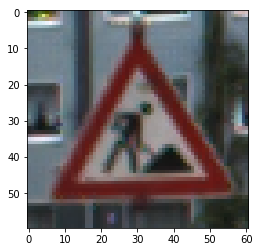

In [57]:
n = 29000
print (df.iloc[n])
print (label_names[df.iloc[n]['ClassId']])
img = misc.imread(df.iloc[n]['Path'] + df.iloc[n]['Filename'])
plt.imshow(img)
